## Milestone II

- Supervised Learning Task:   Multi-Domain Recession Forecasting
- Unsupervised Learning Task: Economic Regime Identification

### Current Datasets/Data Sources:
1. Federal Reserve Economic Data (FRED, https://fred.stlouisfed.org/)
   - Contains all(?) of the economic data that we will need (GDP, CPI, unemployment, etc.)
   - Requires API key, obtainable upon registration at their website.
   - The data is sourced from government agencies, international orgs, private companies, research institutions, etc. Metadata for this is available through API. Realistically however, pretty much all the data will come from the OECD (Organisation for Economic Co-operation and Development).
   - Contains information on countries besides the U.S., we will focus on the G7 and maybe a select few other countries, will need to screen for availability and reliability.

### Notes:
- We will be using OECD-based Recession Indicators (https://fred.stlouisfed.org/series/USAREC) as our definition for Recession.


### Import Packages

In [ ]:
import os

import pandas as pd
import numpy as np
import pyfredapi as pf
import warnings

warnings.filterwarnings("ignore")

### Setup API Key

#### To use FRED in this notebook:

1. Get an API key from https://fredaccount.stlouisfed.org/login/secure/, register if needed.
2. Add to your operating systems environment variables

In [ ]:
# load FRED API key from environment, if this fails read above
if os.environ.get("FRED_API_KEY") is None:
    print("Failed to get FRED API Key!")


### Get data from FRED

Getting data from FRED requires knowing the series ID of the data you want.

Most series IDs will comprise of a country code (2 or 3 letter) combined with a series prefix/suffix or just a suffix.

You can look them up individually at https://fred.stlouisfed.org/

I avoid hardcoding them and instead generate them using their pattern, that way we can more easily add new series data.

In [6]:
def get_series_metadata(series_id: str) -> dict:
    """Retrieves source metadata and release URLs for a specific data series.

    Args:
        series_id: The unique identifier for the FRED data series (e.g., 'GDPC1').

    Returns:
        A dictionary containing metadata with the following keys:
            - series_title: title of the data series
            - series_notes: notes about the series
            - dataset_url: link to the dataset release
            - source_name: name of the data source organization
            - source_url: URL of the source organization
            - frequency: frequency of the data (e.g., monthly, quarterly)
            - units: units of measurement for the data values
    """

    source_dict = {}

    series_info = pf.get_series_info(series_id=series_id)
    source_dict["series_title"] = series_info.title
    source_dict["series_notes"] = series_info.notes
    source_dict["frequency"] = series_info.frequency
    source_dict["units"] = series_info.units

    release_info = pf.get_series_releases(series_id=series_id)
    release_id = release_info["releases"][0]["id"]

    source_dict["dataset_url"] = release_info["releases"][0]["link"]

    release_sources = pf.get_release_sources(release_id=release_id)
    source_dict["source_name"] = release_sources["sources"][0]["name"]
    source_dict["source_url"] = release_sources["sources"][0]["link"]

    return source_dict

# G7 country codes for constructing FRED series IDs
G7_COUNTRY_CODES = {
    "USA": {"iso2": "US", "iso3": "USA"},
    "Canada": {"iso2": "CA", "iso3": "CAN"},
    "UK": {"iso2": "GB", "iso3": "GBR"},
    "France": {"iso2": "FR", "iso3": "FRA"},
    "Germany": {"iso2": "DE", "iso3": "DEU"},
    "Italy": {"iso2": "IT", "iso3": "ITA"},
    "Japan": {"iso2": "JP", "iso3": "JPN"},
}


######################## NEW FRED DATA ADDED HERE #########################################################
# prefix goes before the country code (can be empty)
# suffix goes after
# use_iso3 flag for whether to use 3 letter version or 2 letter ver
# suffix_overrides allows country-specific suffixes where patterns differ
# iso_overrides allows country-specific ISO code overrides
# I will include notes here as well as URLs to the USA series data
SERIES_PATTERN = {
    # Real GDP, quarterly, in national currency units, seasonally adj.
    # USA URL: https://fred.stlouisfed.org/series/NAEXKP01USQ652S
    "real_gdp": {
        "prefix": "NAEXKP01",
        "suffix": "Q189S",
        "use_iso3": False,
        "suffix_overrides": {"USA": "Q652S", "UK": "Q652S"},
    },
    # Consumer Price Index, 2015=100, monthly
    # USA URL: https://fred.stlouisfed.org/series/USACPIALLMINMEI
    "cpi": {
        "prefix": "",
        "suffix": "CPIALLMINMEI",
        "use_iso3": True,
    },
    # Unemployment Rate (%), Monthly, Seasonally Adj.
    # USA URL: https://fred.stlouisfed.org/series/LRHUTTTTUSM156S
    "unemployment_rate": {
        "prefix": "LRHUTTTT",
        "suffix": "M156S",
        "use_iso3": False,
    },
    # Economic Policy Uncertainty Index, Monthly
    # USA URL: https://fred.stlouisfed.org/series/USEPUINDXM
    # Japan's is discontinued on FRED in 2016, the original source has up to
    # present. https://policyuncertainty.com/japan_monthly.html
    # Will correct later.
    "epu": {
        "prefix": "",
        "suffix": "EPUINDXM",
        "use_iso3": False,
        "suffix_overrides": {"France": "EUINDXM"},
        "iso_overrides": {"Japan": "JPN", "UK": "UK", "Canada": "CAN"},
    },
    # 10 Year Government Bond Interest Rates, Monthly
    # USA URL: https://fred.stlouisfed.org/series/IRLTLT01USM156N
    "10_yr_yld": {
        "prefix": "IRLTLT01",
        "suffix": "M156N",
        "use_iso3": False,
    },
    # 3-Month Interbank Interest Rate, Monthly
    # USA URL: https://fred.stlouisfed.org/series/IR3TIB01USM156N
    # This is the interest rate that banks charge other banks for a 90-day loan
    # not using 3 month government bond yield as it's not available for all G7 countries
    "3_mo_yld": {
        "prefix": "IR3TIB01",
        "suffix": "M156N",
        "use_iso3": False,
    },
    # OECD based Recession Indicators, Monthly
    # USA URL: https://fred.stlouisfed.org/series/USAREC
    # Discontinued since 2022 but can be used for historical analysis
    # Can find alternatives if needed
    "oecd_rec": {
        "prefix": "",
        "suffix": "REC",
        "use_iso3": True,
    },
    # Industrial Activity Index, Monthly, Seasonally Adj.
    # USA URL: https://fred.stlouisfed.org/series/USAPRINTO01IXOBM
    "ind_out": {
        "prefix": "",
        "suffix": "PROINDMISMEI",
        "use_iso3": True,
    },
    # Composite Consumer Confidence Amplitude, Monthly, Seasonally Adj.
    # USA URL: https://fred.stlouisfed.org/series/CSCICP03USM665S
    # Normal is 100
    "comp_consumer_conf": {
        "prefix": "CSCICP03",
        "suffix": "M665S",
        "use_iso3": False,
    },
    # Car Registration for Passenger Cars, Monthly, Seasonally Adj.
    # USA URL: https://fred.stlouisfed.org/series/USASLRTCR03GPSAM
    "pcar_reg":{
      "prefix": "",
      "suffix": "SLRTCR03GPSAM",
      "use_iso3": True,
    },
    # VIX - Daily data, aggregated to monthly via average
    # URL: https://fred.stlouisfed.org/series/VIXCLS
    "vix": {
        "prefix": "VIXCLS",
        "suffix": "",
        "use_iso3": False,
        "is_global": True,
        "agg_method": "avg",  # pyfredapi aggregation_method param
    }
}


def build_series_id(indicator: str, country: str) -> str:
    """Constructs a FRED series ID from template and country code.

    Args:
        indicator: The indicator type (e.g., 'real_gdp', 'cpi').
        country: The country name (e.g., 'USA', 'UK').

    Returns:
        The constructed FRED series ID string.

    Raises:
        ValueError: If indicator or country is not recognized.
    """
    if indicator not in SERIES_PATTERN:
        raise ValueError(f"Unknown indicator: {indicator}")
    if country not in G7_COUNTRY_CODES:
        raise ValueError(f"Unknown country: {country}")

    template = SERIES_PATTERN[indicator]
    codes = G7_COUNTRY_CODES[country]

    # Global indicators don't use country codes
    if template.get("is_global", False):
        return f"{template['prefix']}{template['suffix']}"

    # Check for country-specific ISO override first
    iso_overrides = template.get("iso_overrides", {})
    if country in iso_overrides:
        code = iso_overrides[country]
    else:
        code = codes["iso3"] if template["use_iso3"] else codes["iso2"]

    suffix_overrides = template.get("suffix_overrides", {})
    suffix = suffix_overrides.get(country, template["suffix"])

    return f"{template['prefix']}{code}{suffix}"


def build_series_dict(
    indicators: list[str] | None = None,
    countries: list[str] | None = None,
) -> dict[str, dict[str, str]]:
    """Builds a nested dictionary of FRED series IDs.

    Args:
        indicators: List of indicators to include all by default
        countries: List of countries to include all by default

    Returns:
        Nested dict: {indicator: {country: series_id, country2: series_id2}, indicator2: ...}
        For global indicators, all countries map to the same series ID.
    """
    indicators = indicators or list(SERIES_PATTERN.keys())
    countries = countries or list(G7_COUNTRY_CODES.keys())

    series_ids_by_indicator = {}

    for indicator in indicators:
        template = SERIES_PATTERN[indicator]
        is_global = template.get("is_global", False)

        if is_global:
            # Global indicators use the same series ID for all countries
            global_series_id = build_series_id(indicator, countries[0])
            series_ids_by_country = {country: global_series_id for country in countries}
        else:
            series_ids_by_country = {
                country: build_series_id(indicator, country) for country in countries
            }

        series_ids_by_indicator[indicator] = series_ids_by_country

    return series_ids_by_indicator



def get_fred_data(
    series_dict: dict[str, dict[str, str]] | None = None,
    indicators: list[str] | None = None,
    countries: list[str] | None = None,
    start_date: str | None = "1970-01-01",
    end_date: str | None = "2020-12-31",
) -> pd.DataFrame:
    """Fetches FRED data for multiple series and compiles it into a DataFrame.

    Args:
        series_dict: Nested dictionary mapping indicator types to country-series mappings.
            If None, builds from templates using indicators/countries filters.
        indicators: List of indicators to include (used if series_dict is None).
        countries: List of countries to include (used if series_dict is None).
        start_date: The earliest date to include in the data (default: '1970-01-01').

    Returns:
        A DataFrame with (date, country) multi-index and indicator columns.
    """
    if series_dict is None:
        series_dict = build_series_dict(indicators, countries)

    data_frames = []
    fetched_series: dict[str, pd.DataFrame] = {}  # Cache for fetched series

    for indicator in series_dict:
        country_series = series_dict[indicator]
        template = SERIES_PATTERN[indicator]

        for country, series_id in country_series.items():
            # Use cached data if already fetched (for global indicators)
            if series_id not in fetched_series:
                try:
                    # Build optional kwargs for frequency aggregation
                    # If agg_method is defined and is_global, use monthly frequency with specified aggregation
                    kwargs = {}
                    if template.get("is_global", False) and "agg_method" in template:
                        kwargs["frequency"] = "m"
                        kwargs["aggregation_method"] = template["agg_method"]

                    series = pf.get_series(series_id=series_id, **kwargs)
                except Exception as e:
                    print(f"Error fetching data for {series_id}: {e}")
                    raise

                series_df = series[["date", "value"]].copy()
                series_df["date"] = pd.to_datetime(series_df["date"])
                series_df = series_df.set_index("date")

                fetched_series[series_id] = series_df

            df = fetched_series[series_id].copy()
            df = df.rename(columns={"value": (indicator, country)})

            data_frames.append(df)

    result = pd.concat(data_frames, axis=1)
    result.columns = pd.MultiIndex.from_tuples(
        result.columns, names=["indicator", "country"]
    )

    # Upsample quarterly data to monthly with forward fill
    result = result.resample("MS").first().ffill()

    # Filter to start_date onwards
    if start_date is not None:
        result = result.loc[start_date:]

    # Filter to end_date
    if end_date is not None:
        result = result.loc[:end_date]

    result = result.stack(level="country")

    return result


def engineer_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Convert OECD recession flag to boolean
    df["oecd_rec"] = df["oecd_rec"].astype(bool)

    # Calculate quarter over quarter GDP growth rate (GDP is quarterly data)
    df["gdp_qoq_growth"] = (
        df.groupby(level="country")["real_gdp"].pct_change(periods=3) * 100
    )

    # Technical recession: two consecutive quarters of negative GDP growth
    df["technical_rec"] = (df["gdp_qoq_growth"] < 0) & (
        df.groupby(level="country")["gdp_qoq_growth"].shift(3) < 0
    )

    # Spread between 10-year and 3-month yields
    # This being negative is a commonly used metric for recession
    df["yield_curve"] = df["10_yr_yld"] - df["3_mo_yld"]

    return df

df = get_fred_data()

df = engineer_features(df)

# Scale GDP to billions for readability
df_display = df.copy()
df_display["real_gdp"] = df_display["real_gdp"] / 1e9

# It defaults to a indicator, country multi-index df
print("\n\nDataFrame Tail (GDP in billions):")
print(df_display.round(2).tail(14))

# Can also unstack for super wide date, country multi-index (I don't recommend it)
# print("\n\nDataFrame Tail (Unstacked, GDP in billions):")
# print(df_display.unstack(level="country").round(2).tail(10))

# Can also only get specific indicators/countries
# df_usa_gdp = get_fred_data(indicators=["real_gdp"], countries=["USA", "UK"])

print("\n\nData from specific dates:")
specific_dates = ["1980-01-01", "2000-01-01", "2020-01-01"]
print(df_display.loc[specific_dates].round(2))

print("\n\nData from 2008 financial crisis period:")
print(df_display.loc["2008-06-01":"2009-06-01"].round(2))



DataFrame Tail (GDP in billions):
indicator            real_gdp     cpi  unemployment_rate     epu  10_yr_yld  \
date       country                                                            
2020-11-01 Canada      546.81  108.80                8.6  455.05       0.69   
           France      559.95  104.73                8.1  403.89      -0.32   
           Germany     796.47  105.11                3.8  387.49      -0.61   
           Italy       404.56  102.40                9.5  279.39       0.66   
           Japan    134994.38  101.30                3.0  110.08       0.03   
           UK          514.53  109.10                5.3  313.84       0.38   
           USA       20724.13  109.79                6.7  246.71       0.87   
2020-12-01 Canada      546.81  108.56                8.9  371.18       0.73   
           France      559.95  104.96                7.9  257.27      -0.34   
           Germany     796.47  105.22                3.8  227.94      -0.62   
           Italy

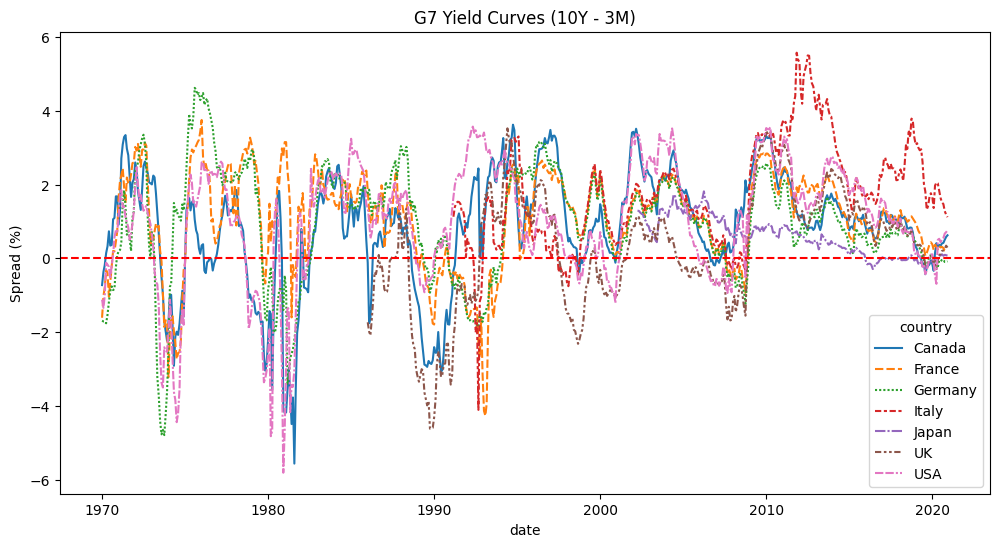

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Unstack to get countries as columns for the yield_curve indicator
yield_data = df_display["yield_curve"].unstack(level="country")

plt.figure(figsize=(12, 6))
sns.lineplot(data=yield_data)
plt.axhline(0, color='red', linestyle='--', label="Inversion Line")
plt.title("G7 Yield Curves (10Y - 3M)")
plt.ylabel("Spread (%)")
plt.show()